<a href="https://colab.research.google.com/github/sri299792458/stat8105_finetuning_paligemma/blob/main/big_vision/configs/proj/paligemma/finetune_paligemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetune PaliGemma

> *These models and code are not official Google products and were trained and released for research purposes.*


**This notebook shows how to finetune PaliGemma 2 on a vision-language task.**
The training data consists of 90 pairs of images and long captions describing them.
To make it runnable on a T4 colab runtime with 16GB HBM and 12GB RAM, we opt to only finetune the attention layers of the language model and freeze the other parameters.

 **This setup is illustrative**. In a real usecase, the amount of data, trainable parameters, training steps and hyper-parameters and obtained results could be significantly different.

This notebook uses the model reference implementation from [big_vision](https://github.com/google-research/big_vision).
and shows how to:

 * Install deps, download model checkpoint and training data.
 * Load the model onto GPU devices.
 * Prepare the input to the model for training and inference.
 * Finetune the model and inspect output in validation split.

## Setup

In [3]:
# @title Fetch big_vision code and install dependencies.
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.5 MB/s eta 0:00:00


### Configure your API key to access Kaggle

To use PaliGemma, you must provide your Kaggle username and a Kaggle API key.

1. To generate a Kaggle API key, go to the **Account** tab of your Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing your API credentials.
1. In Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

To be able to download, you will also need to acknowledge the Terms and Conditions of the PaliGemma on:

* https://www.kaggle.com/models/google/paligemma/



In [4]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

# The T4 runtime is tight on memory to finetune this model. Preallocate
# all memory ahead of time to avoid OOM'ing due to fragmentation.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

In [5]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import os
import kagglehub

# Use these for PaliGemma-2 3B 224px²
LLM_VARIANT = "gemma2_2b"
MODEL_PATH = "/content/drive/MyDrive/paligemma_assets/paligemma2-3b-pt-224.b16.npz"
KAGGLE_HANDLE = "google/paligemma-2/jax/paligemma2-3b-pt-224"  # Path to fetch from Kaggle.

# Use these for PaliGemma 1:
# LLM_VARIANT = "gemma_2b"
# MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
# KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224"

if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "/content/drive/MyDrive/paligemma_assets/paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

# DATA_DIR="./longcap100"
# if not os.path.exists(DATA_DIR):
#   print("Downloading the dataset...")
#   !gsutil -m -q cp -n -r gs://longcap100/ .
#   print(f"Data path: {DATA_DIR}")

## Notebook

In [6]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.5.3
JAX platform: gpu
JAX devices:  1


In [7]:
# @title Construct model and load params into RAM.

# Define model
# IMPORTANT: Gemma-2 has a "final_logits_softcap" property, we set it to 0.0
# for better transfer results.
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

In [8]:
# @title Move params to GPU/TPU memory.
#
# To keep HBM usage low and fit in a T4 GPU (16GB HBM) we opt to only finetune
# a part of the parameters. Additionally we keep the frozen params in float16
# and cast trainable to float32.

# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

#
# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  # Cast others to float16, since some GPUs don't support bf16.
  return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                      if m else p.astype(jnp.float16),
                      params, trainable)

In [9]:
# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default (12GB RAM).
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

In [35]:
def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [36]:
# ==============================================================================
# SECTION 1: IMPORTS AND CONSTANTS FOR DATA PREP
# ==============================================================================
import os
import glob
import random
import re
import itertools
from PIL import Image
from tqdm.notebook import tqdm

# Constants for our specific dataset and task
PROMPT_PREFIX = "detect grasp"
ORIGINAL_IMG_WIDTH = 640
ORIGINAL_IMG_HEIGHT = 480
SEQLEN = 64

# ==============================================================================
# SECTION 2: DATASET CREATION LOGIC
# ==============================================================================

def create_cornell_dataset(root_path):
    """
    Creates the full list of training examples from the Cornell Grasp dataset
    using the official PaliGemma detection format.
    """
    print(f"Searching for annotation files in: {root_path}")
    annotation_files = glob.glob(os.path.join(root_path, '**', '*cpos.txt'), recursive=True)

    data_examples = []
    skipped_files = 0

    print("Processing annotation files...")
    for txt_file in tqdm(annotation_files, desc="Processing files"):
        image_path = txt_file.replace('cpos.txt', 'r.png')
        if os.path.exists(image_path):
            try:
                with open(txt_file, 'r') as f:
                    lines = f.read().strip().split('\n')

                for i in range(0, len(lines), 4):
                    if i + 3 < len(lines):
                        coords = [lines[i+j].split() for j in range(4)]
                        x_coords = [float(p[0]) for p in coords]
                        y_coords = [float(p[1]) for p in coords]

                        xmin, ymin = min(x_coords), min(y_coords)
                        xmax, ymax = max(x_coords), max(y_coords)

                        loc_ymin = f"<loc{int((ymin / ORIGINAL_IMG_HEIGHT) * 1024)}>"
                        loc_xmin = f"<loc{int((xmin / ORIGINAL_IMG_WIDTH) * 1024)}>"
                        loc_ymax = f"<loc{int((ymax / ORIGINAL_IMG_HEIGHT) * 1024)}>"
                        loc_xmax = f"<loc{int((xmax / ORIGINAL_IMG_WIDTH) * 1024)}>"

                        suffix = f"{loc_ymin}{loc_xmin}{loc_ymax}{loc_xmax} grasp"
                        data_examples.append({'image_path': image_path, 'suffix': suffix})
            except Exception:
                skipped_files += 1
                continue

    if skipped_files > 0:
        print(f"  [!] Total skipped files due to errors: {skipped_files}")

    return data_examples

# ==============================================================================
# SECTION 3: FINAL DATA ITERATOR DEFINITIONS
# ==============================================================================

# 1. Create the full list of examples from our custom dataset
local_dataset_path = '/content/Cornell_Grasp_Kaggle' # Assumes data was copied locally
all_examples = create_cornell_dataset(local_dataset_path)
random.shuffle(all_examples)

# 2. Split into training and validation sets
split_ratio = 0.9
split_idx = int(len(all_examples) * split_ratio)
train_examples = all_examples[:split_idx]
val_examples = all_examples[split_idx:]
print(f"\nDataset created: {len(train_examples)} training examples, {len(val_examples)} validation examples.")

# 3. Define the iterator functions with the required names
def train_data_iterator():
    """Never-ending iterator over our custom training examples."""
    for example in itertools.cycle(train_examples):
        image = Image.open(example["image_path"])
        image = preprocess_image(image)
        tokens, mask_ar, mask_loss, _ = preprocess_tokens(
            prefix=PROMPT_PREFIX, suffix=example["suffix"], seqlen=SEQLEN)
        yield {"image": image, "text": tokens, "mask_ar": mask_ar, "mask_loss": mask_loss}

def validation_data_iterator():
    """Single iterator over validation examples, using tf.data for full compatibility."""

    # A generator function is needed for tf.data.Dataset
    def validation_generator():
        for example in val_examples:
            image = Image.open(example["image_path"])
            image_processed = preprocess_image(image)

            tokens, mask_ar, _, mask_input = preprocess_tokens(
                prefix=PROMPT_PREFIX, seqlen=SEQLEN) # Using your desired SEQLEN

            yield {
                "image": image_processed,
                "text": tokens,
                "mask_ar": mask_ar,
                "mask_input": mask_input
            }

    # Define the exact shape and type of each element the generator yields
    output_signature = {
        "image": tf.TensorSpec(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32),
        "text": tf.TensorSpec(shape=(SEQLEN,), dtype=tf.int32),
        "mask_ar": tf.TensorSpec(shape=(SEQLEN,), dtype=tf.int32),
        "mask_input": tf.TensorSpec(shape=(SEQLEN,), dtype=tf.int32),
    }

    # Create the tf.data.Dataset from our generator
    val_tf_dataset = tf.data.Dataset.from_generator(
        validation_generator,
        output_signature=output_signature
    )

    # Yield from the dataset's numpy iterator, just like the original notebook
    for example in val_tf_dataset.as_numpy_iterator():
        yield example

Searching for annotation files in: /content/Cornell_Grasp_Kaggle
Processing annotation files...


Processing files:   0%|          | 0/885 [00:00<?, ?it/s]

  [!] Total skipped files due to errors: 1

Dataset created: 4599 training examples, 511 validation examples.


In [43]:
import base64
import html
import io
import re
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display, HTML

# --- Function to decode the model's token output into pixel coordinates ---
def decode_bbox_from_output(output_string):
    """Parses a model's output string to extract bounding box coordinates."""
    loc_values = re.findall(r'<loc(\d+)>', output_string)
    if len(loc_values) < 4:
        return None
    try:
        vals = [int(v) for v in loc_values]
        ymin = (vals[0] / 1024) * ORIGINAL_IMG_HEIGHT
        xmin = (vals[1] / 1024) * ORIGINAL_IMG_WIDTH
        ymax = (vals[2] / 1024) * ORIGINAL_IMG_HEIGHT
        xmax = (vals[3] / 1024) * ORIGINAL_IMG_WIDTH
        # Return as [xmin, ymin, xmax, ymax] for PIL's rectangle function
        return [int(xmin), int(ymin), int(xmax), int(ymax)]
    except (ValueError, IndexError):
        return None

# --- Helper function from the original notebook to display images ---
def render_inline(image, resize=(256, 256)):
    """Convert PIL image into inline HTML."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_detection_example(image_array, model_output):
    """
    Renders an image with its predicted bounding box, now with correct coordinate scaling.
    """
    # Convert from [-1, 1] numpy array to a [0, 255] PIL Image
    # The size of this image will be 224x224 pixels.
    image_array = ((image_array + 1) / 2 * 255).astype(np.uint8)
    image = Image.fromarray(image_array)
    draw = ImageDraw.Draw(image)

    # Decode coordinates, which are relative to the ORIGINAL 640x480 size
    bbox_coords_orig = decode_bbox_from_output(model_output)

    if bbox_coords_orig:
        # --- THE FIX IS HERE ---
        # We must rescale the coordinates from the original 640x480 space
        # to the 224x224 space of the image we are drawing on.
        xmin_orig, ymin_orig, xmax_orig, ymax_orig = bbox_coords_orig

        display_width, display_height = image.size # This will be (224, 224)

        xmin_new = int(xmin_orig * (display_width / ORIGINAL_IMG_WIDTH))
        ymin_new = int(ymin_orig * (display_height / ORIGINAL_IMG_HEIGHT))
        xmax_new = int(xmax_orig * (display_width / ORIGINAL_IMG_WIDTH))
        ymax_new = int(ymax_orig * (display_height / ORIGINAL_IMG_HEIGHT))

        rescaled_coords = [xmin_new, ymin_new, xmax_new, ymax_new]

        # Draw the correctly RESCALED bounding box
        draw.rectangle(rescaled_coords, outline='red', width=2)

    # Create the HTML display block
    return (f'<div style="display: inline-flex; flex-direction: column; margin: 10px;">'
            f'<img style="width:256px; height: 256px;" src="{render_inline(image)}" />'
            f'<p style="width: 256px; margin-top: 5px; font-family: monospace; text-align: center;">{html.escape(model_output)}</p>'
            f'</div>')

In [44]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens, normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

Starting training for 574 steps...
step:   1/574 | lr: 0.00052 | loss: 0.9050

--- Running evaluation at step 1 ---



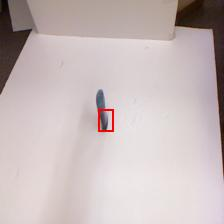
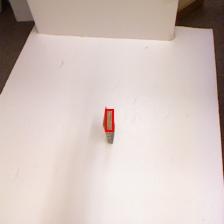
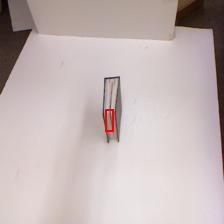
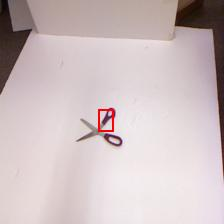

--- Evaluation complete ---

step:   2/574 | lr: 0.00103 | loss: 0.9454
step:   3/574 | lr: 0.00155 | loss: 0.9630
step:   4/574 | lr: 0.00207 | loss: 0.9399
step:   5/574 | lr: 0.00259 | loss: 0.9404
step:   6/574 | lr: 0.00310 | loss: 0.9599
step:   7/574 | lr: 0.00362 | loss: 0.9011
step:   8/574 | lr: 0.00414 | loss: 0.9130
step:   9/574 | lr: 0.00466 | loss: 0.9277
step:  10/574 | lr: 0.00517 | loss: 0.9614
step:  11/574 | lr: 0.00569 | loss: 0.9223
step:  12/574 | lr: 0.00621 | loss: 0.8727
step:  13/574 | lr: 0.00672 | loss: 0.9010
step:  14/574 | lr: 0.00724 | loss: 0.9287
step:  15/574 | lr: 0.00776 | loss: 0.9521
step:  16/574 | lr: 0.00828 | loss: 0.9012
step:  17/574 | lr: 0.00879 | loss: 0.9864
step:  18/574 | lr: 0.00931 | loss: 0.9107
step:  19/574 | lr: 0.00983 | loss: 0.9070
step:  20/574 | lr: 0.01034 | loss: 0.9845

--- Running evaluation at step 20 ---



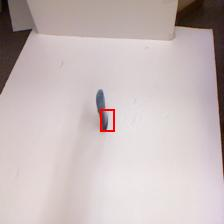
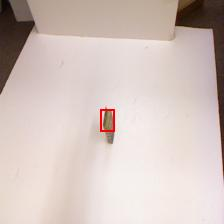
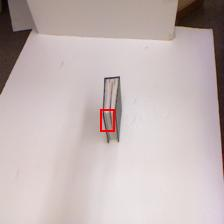
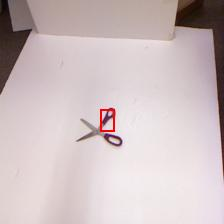

--- Evaluation complete ---

step:  21/574 | lr: 0.01086 | loss: 0.9305
step:  22/574 | lr: 0.01138 | loss: 0.9292
step:  23/574 | lr: 0.01190 | loss: 0.9470
step:  24/574 | lr: 0.01241 | loss: 0.9332
step:  25/574 | lr: 0.01293 | loss: 0.9146
step:  26/574 | lr: 0.01345 | loss: 0.9317
step:  27/574 | lr: 0.01397 | loss: 0.9213
step:  28/574 | lr: 0.01448 | loss: 0.9500
step:  29/574 | lr: 0.01500 | loss: 0.9503
step:  30/574 | lr: 0.01552 | loss: 0.9150
step:  31/574 | lr: 0.01603 | loss: 0.9259
step:  32/574 | lr: 0.01655 | loss: 0.9358
step:  33/574 | lr: 0.01707 | loss: 0.9407
step:  34/574 | lr: 0.01759 | loss: 0.9016
step:  35/574 | lr: 0.01810 | loss: 0.9177
step:  36/574 | lr: 0.01862 | loss: 0.8814
step:  37/574 | lr: 0.01914 | loss: 0.9189
step:  38/574 | lr: 0.01966 | loss: 0.9301
step:  39/574 | lr: 0.02017 | loss: 0.9248
step:  40/574 | lr: 0.02069 | loss: 0.9152

--- Running evaluation at step 40 ---



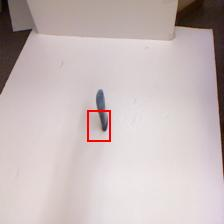
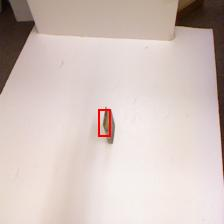
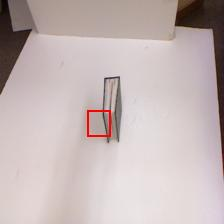
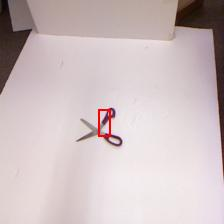

--- Evaluation complete ---

step:  41/574 | lr: 0.02121 | loss: 0.9229
step:  42/574 | lr: 0.02172 | loss: 0.9053
step:  43/574 | lr: 0.02224 | loss: 0.9216
step:  44/574 | lr: 0.02276 | loss: 0.9642
step:  45/574 | lr: 0.02328 | loss: 0.9582
step:  46/574 | lr: 0.02379 | loss: 0.9883
step:  47/574 | lr: 0.02431 | loss: 0.9343
step:  48/574 | lr: 0.02483 | loss: 0.9157
step:  49/574 | lr: 0.02534 | loss: 0.9184
step:  50/574 | lr: 0.02586 | loss: 0.9274
step:  51/574 | lr: 0.02638 | loss: 0.9349
step:  52/574 | lr: 0.02690 | loss: 0.9771
step:  53/574 | lr: 0.02741 | loss: 0.9494
step:  54/574 | lr: 0.02793 | loss: 0.9016
step:  55/574 | lr: 0.02845 | loss: 0.8764
step:  56/574 | lr: 0.02897 | loss: 0.9694
step:  57/574 | lr: 0.02948 | loss: 0.9557
step:  58/574 | lr: 0.03000 | loss: 0.9310
step:  59/574 | lr: 0.03000 | loss: 0.9718
step:  60/574 | lr: 0.03000 | loss: 0.9119

--- Running evaluation at step 60 ---



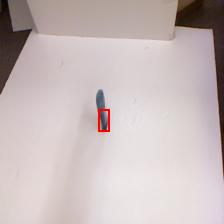
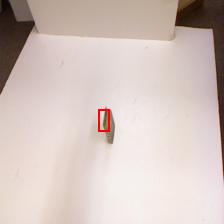
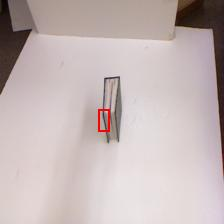
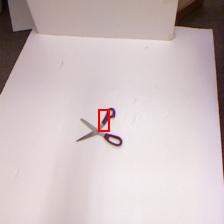

--- Evaluation complete ---

step:  61/574 | lr: 0.03000 | loss: 0.9410
step:  62/574 | lr: 0.03000 | loss: 0.9155
step:  63/574 | lr: 0.02999 | loss: 0.9247
step:  64/574 | lr: 0.02999 | loss: 0.9034
step:  65/574 | lr: 0.02999 | loss: 0.9178
step:  66/574 | lr: 0.02998 | loss: 0.9927
step:  67/574 | lr: 0.02998 | loss: 0.9537
step:  68/574 | lr: 0.02997 | loss: 0.9401
step:  69/574 | lr: 0.02997 | loss: 0.9113
step:  70/574 | lr: 0.02996 | loss: 0.9608
step:  71/574 | lr: 0.02995 | loss: 0.9364
step:  72/574 | lr: 0.02995 | loss: 0.9615
step:  73/574 | lr: 0.02994 | loss: 0.8980
step:  74/574 | lr: 0.02993 | loss: 0.9608
step:  75/574 | lr: 0.02992 | loss: 0.9054
step:  76/574 | lr: 0.02991 | loss: 0.8970
step:  77/574 | lr: 0.02990 | loss: 0.9306
step:  78/574 | lr: 0.02989 | loss: 0.8842
step:  79/574 | lr: 0.02988 | loss: 0.9743
step:  80/574 | lr: 0.02987 | loss: 0.9101

--- Running evaluation at step 80 ---



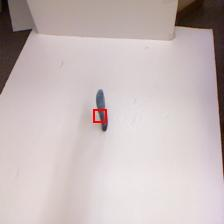
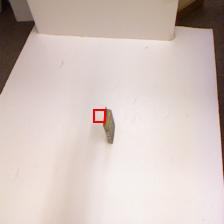
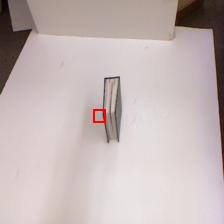
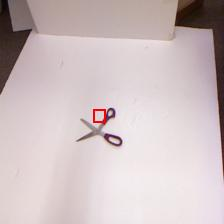

--- Evaluation complete ---

step:  81/574 | lr: 0.02985 | loss: 0.9612
step:  82/574 | lr: 0.02984 | loss: 0.9139
step:  83/574 | lr: 0.02983 | loss: 0.8866
step:  84/574 | lr: 0.02981 | loss: 0.9156
step:  85/574 | lr: 0.02980 | loss: 1.0137
step:  86/574 | lr: 0.02978 | loss: 0.9750
step:  87/574 | lr: 0.02977 | loss: 0.9034
step:  88/574 | lr: 0.02975 | loss: 0.8417
step:  89/574 | lr: 0.02973 | loss: 0.9073
step:  90/574 | lr: 0.02972 | loss: 0.9344
step:  91/574 | lr: 0.02970 | loss: 0.9420
step:  92/574 | lr: 0.02968 | loss: 0.9052
step:  93/574 | lr: 0.02966 | loss: 0.9494
step:  94/574 | lr: 0.02964 | loss: 0.9230
step:  95/574 | lr: 0.02962 | loss: 0.8744
step:  96/574 | lr: 0.02960 | loss: 0.9650
step:  97/574 | lr: 0.02958 | loss: 0.9520
step:  98/574 | lr: 0.02956 | loss: 0.9435
step:  99/574 | lr: 0.02954 | loss: 0.9072
step: 100/574 | lr: 0.02951 | loss: 0.9491

--- Running evaluation at step 100 ---



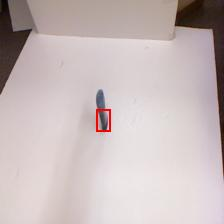
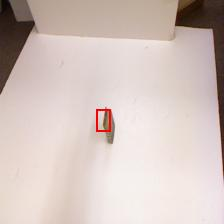
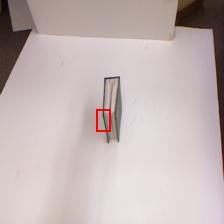
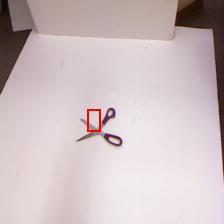

--- Evaluation complete ---

step: 101/574 | lr: 0.02949 | loss: 0.8732
step: 102/574 | lr: 0.02947 | loss: 0.8941
step: 103/574 | lr: 0.02944 | loss: 0.9532
step: 104/574 | lr: 0.02942 | loss: 0.9227
step: 105/574 | lr: 0.02939 | loss: 0.9082
step: 106/574 | lr: 0.02937 | loss: 0.9943
step: 107/574 | lr: 0.02934 | loss: 0.9807
step: 108/574 | lr: 0.02931 | loss: 0.9179
step: 109/574 | lr: 0.02929 | loss: 0.9511
step: 110/574 | lr: 0.02926 | loss: 0.9714
step: 111/574 | lr: 0.02923 | loss: 0.9390
step: 112/574 | lr: 0.02920 | loss: 0.9264
step: 113/574 | lr: 0.02917 | loss: 0.8862
step: 114/574 | lr: 0.02914 | loss: 0.9029


In [ ]:
# ==============================================================================
# FINAL CORRECTED TRAINING LOOP
# ==============================================================================

# --- 1. Define Training Parameters ---
BATCH_SIZE = 8
TRAIN_EXAMPLES = 4599 # Using the full training set for one epoch
LEARNING_RATE = 0.03
TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 5

# --- 2. Create Learning Rate Schedule and Training Iterator ---
train_data_it = train_data_iterator()
sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS + 1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

# --- 3. Run the Training and Evaluation Loop ---
print(f"Starting training for {TRAIN_STEPS} steps...")
start_time = time.time()
for step in range(1, TRAIN_STEPS + 1):
    # --- Training Step ---
    examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

    # ==========================================================================
    # THE FIX IS HERE: Replaced jax.tree.map with a more explicit batching method.
    # This manually stacks the values for each key into a NumPy array.
    # ==========================================================================
    keys = examples[0].keys()
    batch = {k: np.stack([ex[k] for ex in examples]) for k in keys}

    batch = big_vision.utils.reshard(batch, data_sharding)

    learning_rate = sched_fn(step)
    params, loss = update_fn(params, batch, learning_rate)
    loss = jax.device_get(loss)
    print(f"step: {step:3d}/{TRAIN_STEPS:3d} | lr: {learning_rate:.5f} | loss: {loss:.4f}")

    # --- Intermittent Evaluation and Rendering Step ---
    if step == 1 or (step % 20) == 0:
        print(f"\n--- Running evaluation at step {step} ---")
        html_output = ""
        validation_it = validation_data_iterator()

        predictions = make_predictions(validation_it, num_examples=4, batch_size=4)

        for image_array, model_response in predictions:
            html_output += render_detection_example(image_array, model_response)

        display(HTML(html_output))
        print("--- Evaluation complete ---\n")

end_time = time.time()
print(f"\nTraining finished in {end_time - start_time:.2f} seconds.")

# Save the final checkpoint

In [ ]:
def npsave(pytree, path):
  names_and_vals, _ = big_vision.utils.tree_flatten_with_names(pytree)
  with open(path, "wb") as f:
    np.savez(f, **{k:v for k, v in names_and_vals})

# Takes around 4 minutes
npsave(params, 'my-custom-paligemma-ckpt.npz')